In [1]:
from sqlalchemy import create_engine, text, inspect
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Variables globales
engine = None

def connect_to_db():
    global engine
    user = 'root'
    password = 'rootpassword'
    host = '127.0.0.1'
    port = 3309
    db = 'AIRQUALITY'

    connection_string = f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(connection_string)
    print("✅ Conexión a MySQL creada.")


In [3]:
def load_all_dataframes_from_db():
    if engine is None:
        raise Exception("Primero debes ejecutar `connect_to_db()` para establecer la conexión.")

    try:
        DFAQSEP = pd.read_sql("SELECT * FROM DF_AQ_SEP", con=engine)
        DFAQ1 = pd.read_sql("SELECT * FROM DF_AQ_1", con=engine)
        DFAQ2 = pd.read_sql("SELECT * FROM DF_AQ_2", con=engine)

        print("✅ Datos cargados correctamente desde la base de datos.")
        return DFAQSEP, DFAQ1, DFAQ2

    except Exception as e:
        print(f"❌ Error al cargar los datos: {e}")
        return None, None, None


In [4]:
# Primero conectas a la BD
connect_to_db()

# Luego cargas los datos
DFAQSEP, DFAQ1, DFAQ2 = load_all_dataframes_from_db()

✅ Conexión a MySQL creada.
✅ Datos cargados correctamente desde la base de datos.


In [5]:
print(DFAQSEP.head())
print(DFAQ1.head())
print(DFAQ2.head())

       pm2_5  pm10         co   o3   pm5  humidity  temperature  \
0  11.111111  12.0  33.599998  0.1  None       NaN         14.6   
1   5.555555   6.0  12.200000  0.1  None       NaN          9.5   
2   5.555555   6.0  16.100000  0.1  None       NaN          8.5   
3  11.111111  12.0  24.900000  0.4  None       NaN         21.0   
4  12.962963  16.0  31.799999  0.2  None       NaN         17.4   

           time_format  
0  2024-03-15 22:26:36  
1  2024-03-18 02:11:58  
2  2024-03-18 04:57:01  
3  2024-03-19 17:12:33  
4  2024-03-26 18:30:02  
   pm2_5  pm10  co  o3  humidity  temperature  pm5          time_format
0     48    65   7 NaN      61.2         20.2   31  2024-04-08 20:22:00
1      5     6  30 NaN      64.4         19.8    3  2024-04-10 00:00:00
2      7     7   8 NaN      64.6         19.8    4  2024-04-10 00:18:00
3      3     3   4 NaN      66.1         19.9    2  2024-04-10 02:19:00
4      3     3  25 NaN      67.2         19.9    2  2024-04-10 04:07:00
   pm2_5  pm10 

In [6]:
def remove_outliers_and_plot_boxplot(df, column, iqr_factor=1.4):
    """
    Elimina outliers de un DataFrame con base en la columna indicada,
    usando el método IQR, y grafica un boxplot con los cuartiles ajustados.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
        column (str): nombre de la columna a procesar
        iqr_factor (float): multiplicador del IQR para definir límites (default 1.4)

    Retorna:
        pd.DataFrame: nuevo DataFrame sin outliers
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - iqr_factor * IQR
    upper_bound = Q3 + iqr_factor * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    Q1_filtered = df_filtered[column].quantile(0.25)
    Q3_filtered = df_filtered[column].quantile(0.75)

    print(f"👉 Columna: {column}")
    print(f"📊 Registros antes: {df.shape[0]}")
    print(f"✅ Registros después de remover outliers: {df_filtered.shape[0]}")

    # Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df_filtered[column])
    plt.axhline(Q1_filtered, color='red', linestyle='--', label=f'Q1: {Q1_filtered:.2f}')
    plt.axhline(Q3_filtered, color='blue', linestyle='--', label=f'Q3: {Q3_filtered:.2f}')
    plt.title(f'Boxplot de {column.upper()} con Cuartiles Ajustados')
    plt.ylabel('Concentración (µg/m³)')
    plt.legend()
    plt.show()

    return df_filtered


In [7]:
def plot_correlation_map(df, title="Mapa de Correlaciones", figsize=(10, 8), cmap="coolwarm"):
    """
    Genera un mapa de calor con la matriz de correlaciones del DataFrame.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
        title (str): Título del gráfico
        figsize (tuple): Tamaño del gráfico
        cmap (str): Paleta de colores del heatmap

    Retorna:
        None
    """
    # Filtrar solo columnas numéricas
    numeric_df = df.select_dtypes(include='number')

    if numeric_df.shape[1] < 2:
        print("⚠️ El DataFrame debe tener al menos dos columnas numéricas para calcular correlaciones.")
        return

    # Calcular matriz de correlación
    corr = numeric_df.corr()

    # Graficar heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [30]:
def plot_all_boxplots(df, columns=None, title="Boxplot de variables numéricas", figsize=(12, 6)):
    """
    Genera un boxplot para columnas numéricas específicas de un DataFrame.

    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
        columns (list): Lista de nombres de columnas a graficar (opcional)
        title (str): Título del gráfico
        figsize (tuple): Tamaño de la figura

    Retorna:
        None
    """
    # Si no se pasan columnas, usar todas las numéricas
    if columns is None:
        columns = df.select_dtypes(include='number').columns.tolist()

    # Validar que las columnas existan y sean numéricas
    columns = [col for col in columns if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]
    
    if not columns:
        print("⚠️ No hay columnas válidas para graficar.")
        return

    # Transformar a formato largo (long format)
    df_melted = df.melt(value_vars=columns, var_name="Variable", value_name="Valor")

    # Crear boxplot
    plt.figure(figsize=figsize)
    sns.boxplot(x="Variable", y="Valor", data=df_melted)
    plt.title(title)
    plt.xlabel("Variables")
    plt.ylabel("Valores")
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def resample_dataframe_by_time(df, time_column='time_format', freq='H', agg_func='median'):
    """
    Realiza un resampleo temporal de un DataFrame según el índice temporal.

    Parámetros:
        df (pd.DataFrame): DataFrame original con columna de tiempo
        time_column (str): Nombre de la columna de tiempo (por defecto 'time_format')
        freq (str): Frecuencia de resampleo (por defecto 'H' = hora)
        agg_func (str): Función de agregación: 'mean', 'median', 'sum', etc.

    Retorna:
        pd.DataFrame: DataFrame resampleado
    """
    df_copy = df.copy()


    # Asegúrate de que 'time_format' esté en formato datetime
    df_copy[time_column] = pd.to_datetime(df_copy[time_column])

    # Establecer la columna 'time_format' como índice
    df_copy.set_index(time_column, inplace=True)

    # Realizar resampleo con la función agregada
    if agg_func == 'median':
        df_resampled = df_copy.resample(freq).median()
    elif agg_func == 'mean':
        df_resampled = df_copy.resample(freq).mean()
    elif agg_func == 'sum':
        df_resampled = df_copy.resample(freq).sum()
    else:
        raise ValueError("Función de agregación no soportada. Usa: 'mean', 'median', 'sum'.")

    return df_resampled


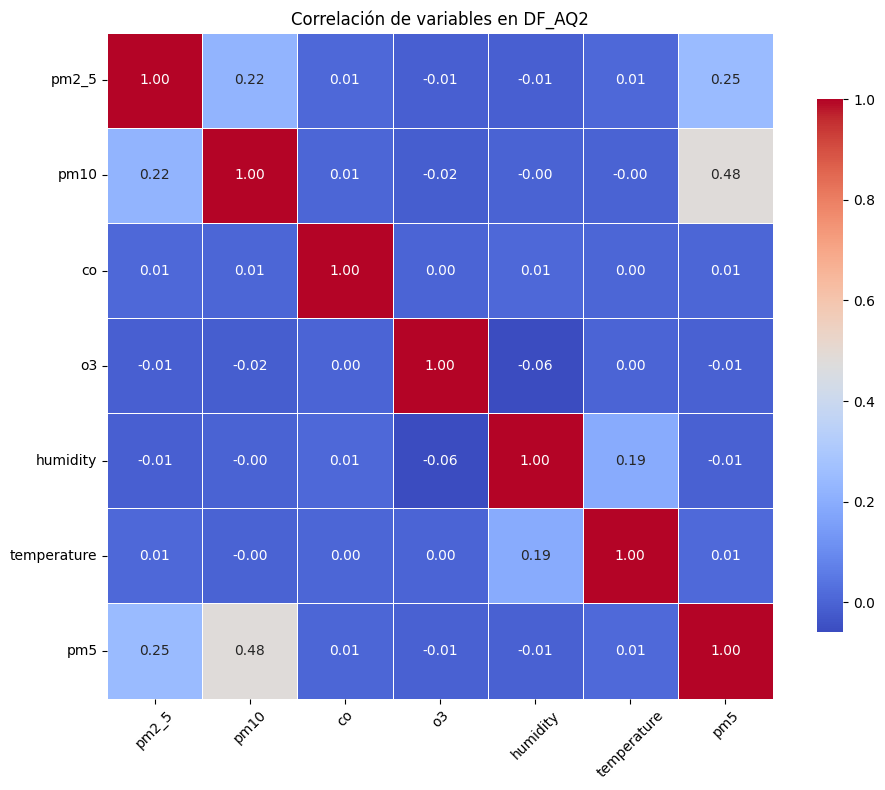

In [11]:
plot_correlation_map(DFAQ2, title="Correlación de variables en DF_AQ2")

👉 Columna: pm2_5
📊 Registros antes: 146015
✅ Registros después de remover outliers: 140179


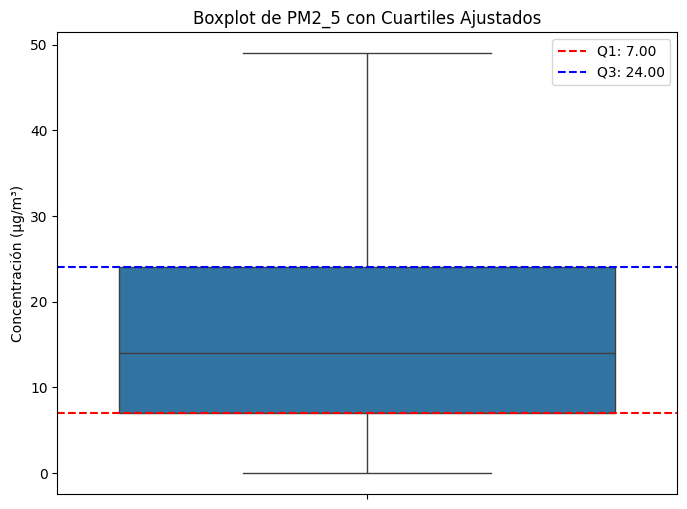

In [12]:
DFAQ2_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQ2, 'pm2_5',1.3)


👉 Columna: pm10
📊 Registros antes: 140179
✅ Registros después de remover outliers: 138087


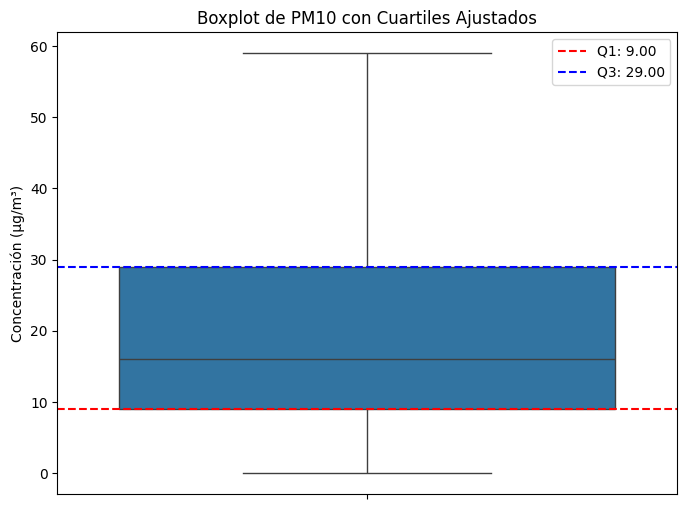

In [13]:
DFAQ2_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5, 'pm10',1.4)


👉 Columna: pm5
📊 Registros antes: 138087
✅ Registros después de remover outliers: 137739


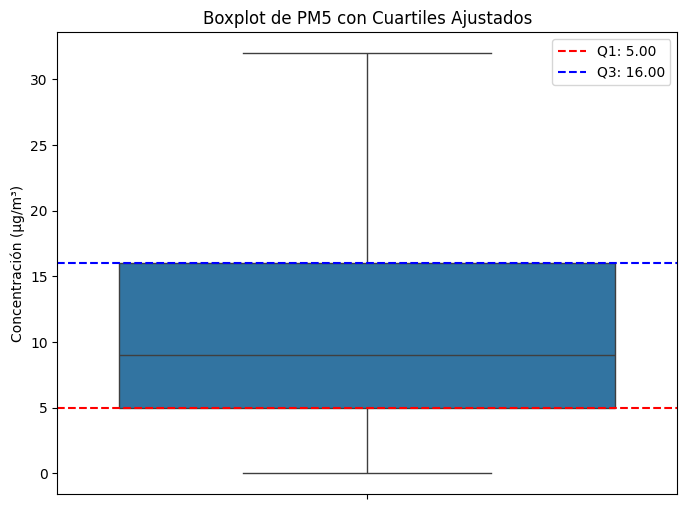

In [14]:
DFAQ2_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_2, 'pm5',1.5)


👉 Columna: temperature
📊 Registros antes: 137739
✅ Registros después de remover outliers: 137445


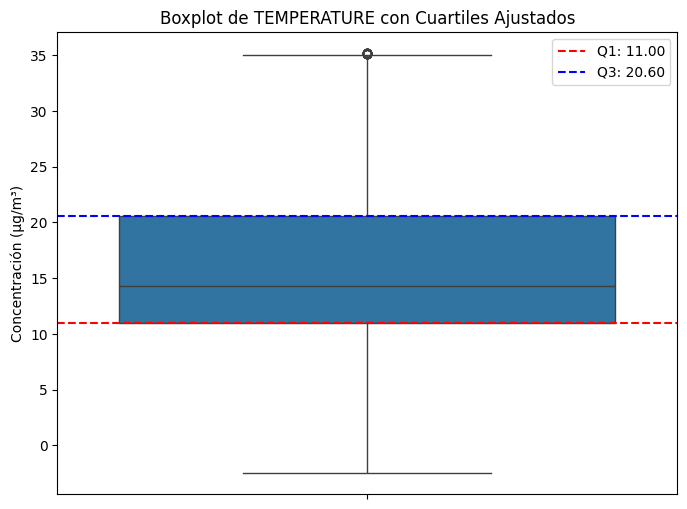

In [15]:
DFAQ2_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_3, 'temperature',1.5)


👉 Columna: humidity
📊 Registros antes: 137445
✅ Registros después de remover outliers: 137445


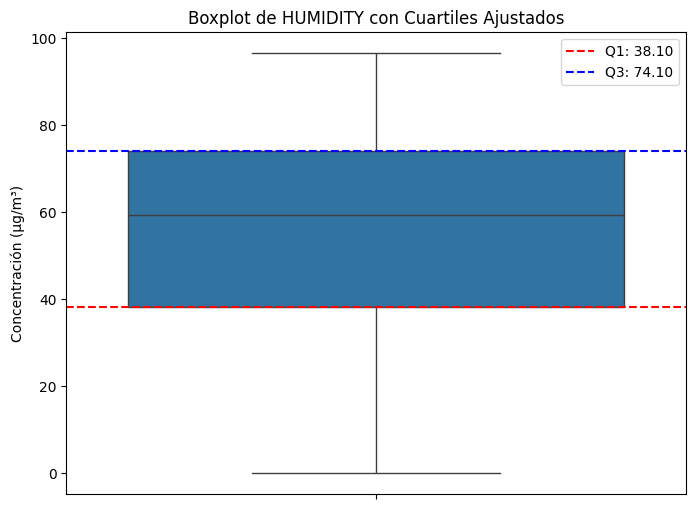

In [16]:
DFAQ2_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_4, 'humidity',1.5)

👉 Columna: co
📊 Registros antes: 137445
✅ Registros después de remover outliers: 137445


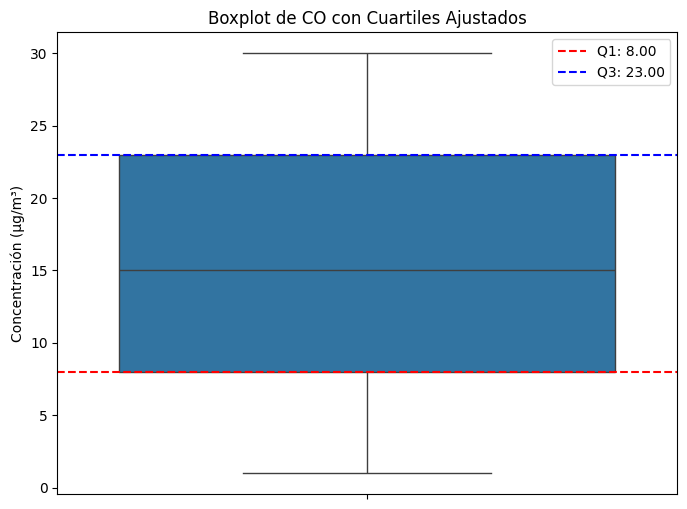

In [17]:
DFAQ2_CPM2_5_6 = remove_outliers_and_plot_boxplot(DFAQ2_CPM2_5_5, 'co',1.5)

In [96]:
DF_AQ2 = DFAQ2_CPM2_5_2

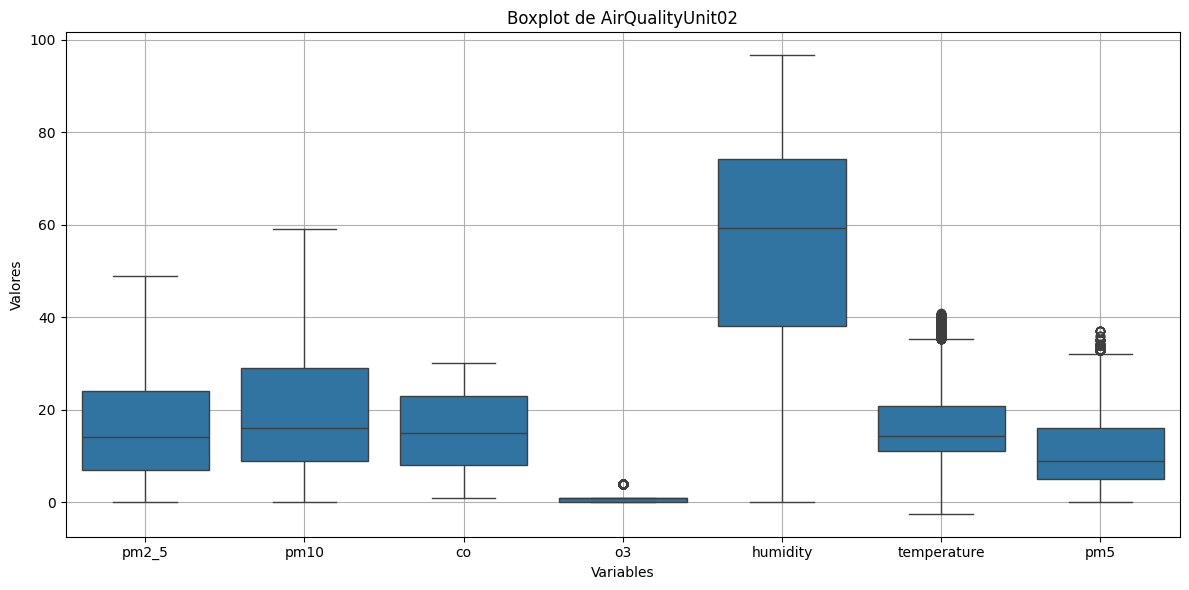

In [97]:
plot_all_boxplots(DF_AQ2, title="Boxplot de AirQualityUnit02")


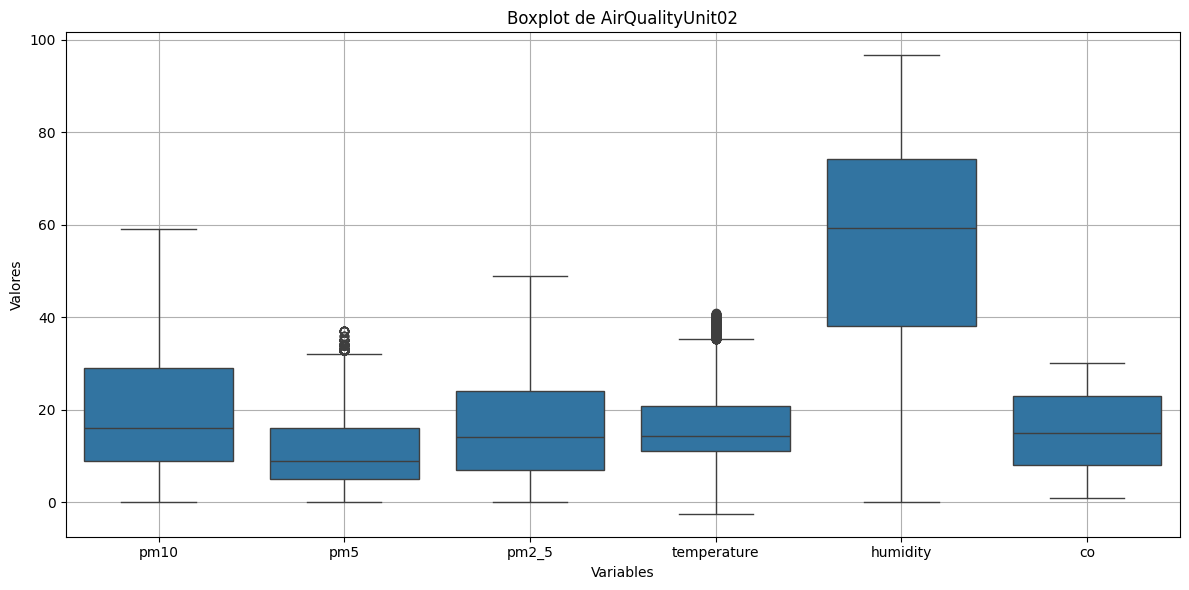

In [103]:
plot_all_boxplots(DF_AQ2, title="Boxplot de AirQualityUnit02",columns=['pm10', 'pm5','pm2_5','temperature','humidity','co'])


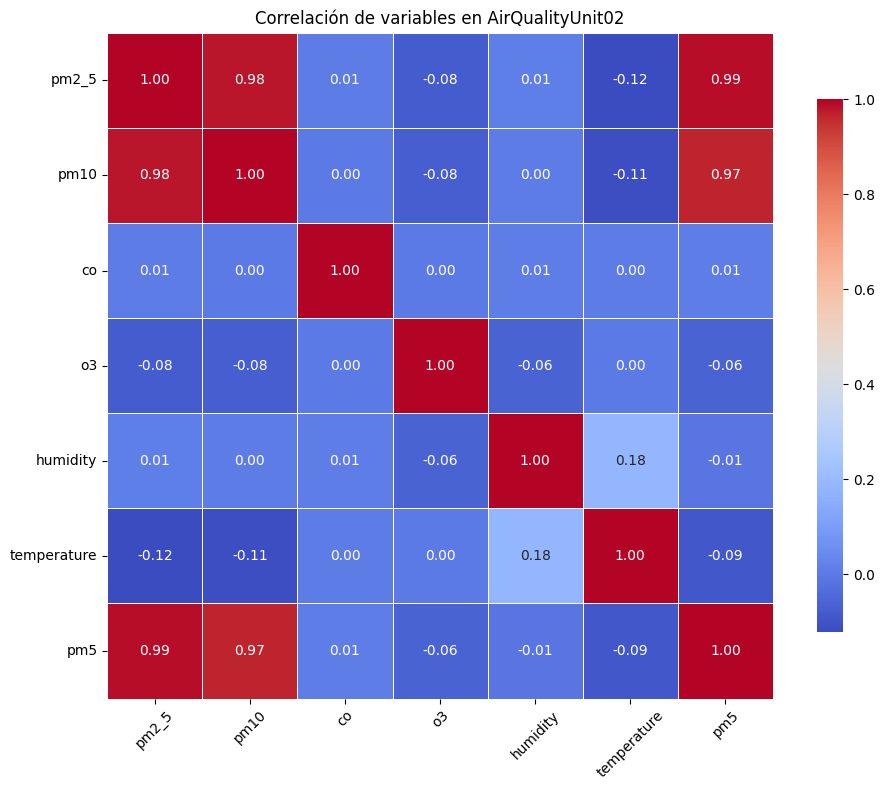

In [99]:
plot_correlation_map(DF_AQ2, title="Correlación de variables en AirQualityUnit02")


👉 Columna: pm2_5
📊 Registros antes: 179391
✅ Registros después de remover outliers: 174962


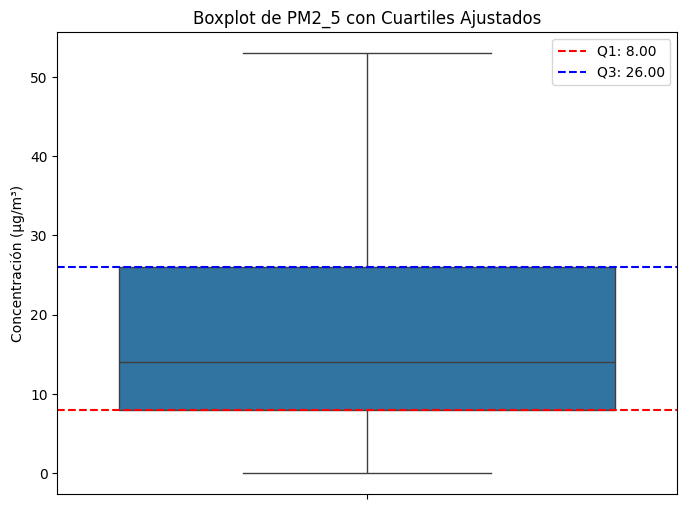

In [49]:
DFAQ1_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQ1, 'pm2_5',1.4)

👉 Columna: pm10
📊 Registros antes: 174962
✅ Registros después de remover outliers: 174458


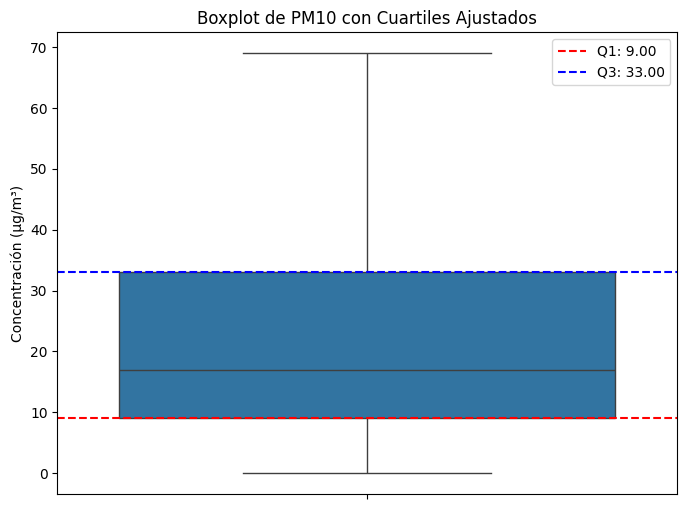

In [50]:
DFAQ1_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5, 'pm10',1.5)

👉 Columna: pm5
📊 Registros antes: 174458
✅ Registros después de remover outliers: 172995


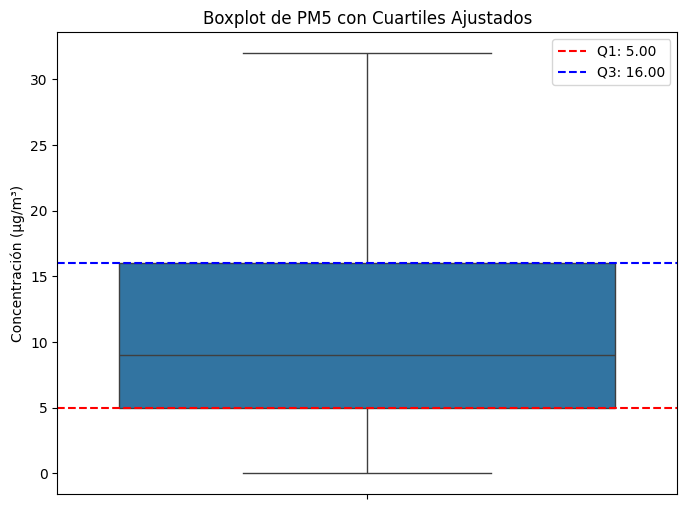

In [51]:
DFAQ1_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_2, 'pm5',1.5)

👉 Columna: temperature
📊 Registros antes: 172995
✅ Registros después de remover outliers: 172973


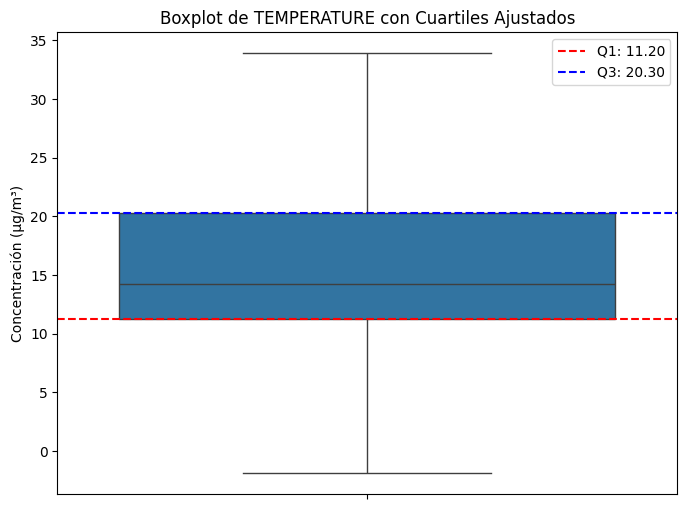

In [52]:
DFAQ1_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_3, 'temperature',1.5)

👉 Columna: humidity
📊 Registros antes: 172973
✅ Registros después de remover outliers: 172973


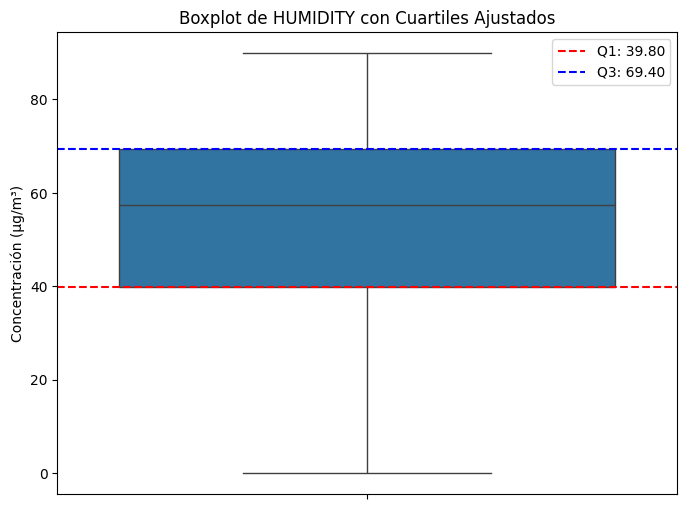

In [53]:
DFAQ1_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_4, 'humidity',1.4)

👉 Columna: co
📊 Registros antes: 172973
✅ Registros después de remover outliers: 159361


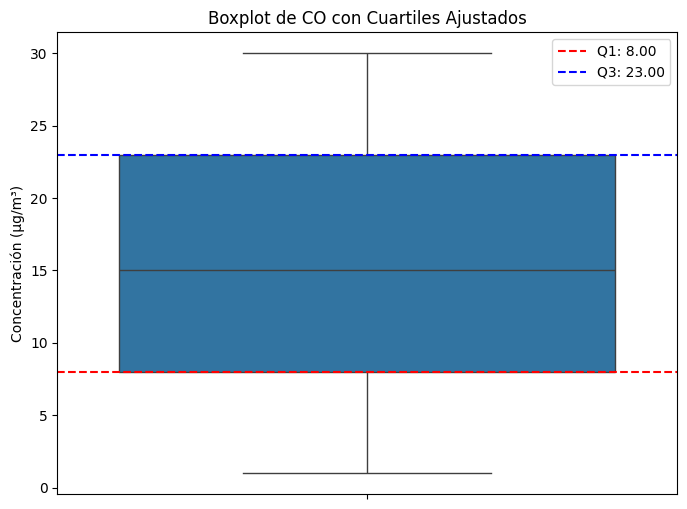

In [54]:
DFAQ1_CPM2_5_6 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_5, 'co',1.5)

👉 Columna: o3
📊 Registros antes: 159361
✅ Registros después de remover outliers: 13592


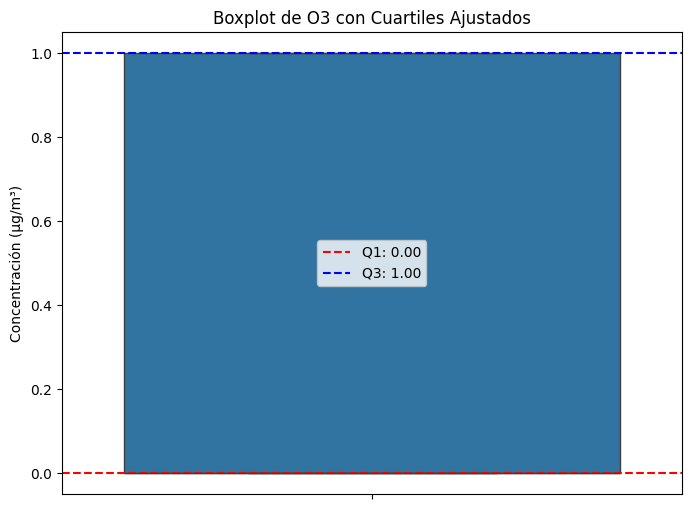

In [55]:
DFAQ1_CPM2_5_7 = remove_outliers_and_plot_boxplot(DFAQ1_CPM2_5_6, 'o3',1.5)

In [57]:
DF_AQ1 = DFAQ1_CPM2_5_2

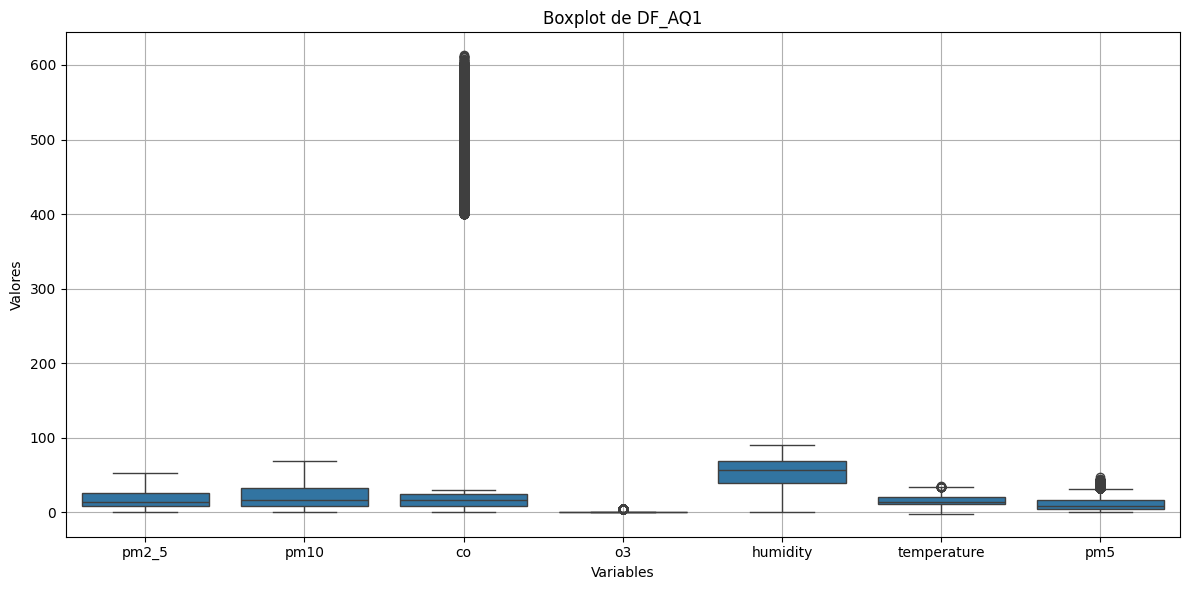

In [104]:
plot_all_boxplots(DF_AQ1, title="Boxplot de DF_AQ1")

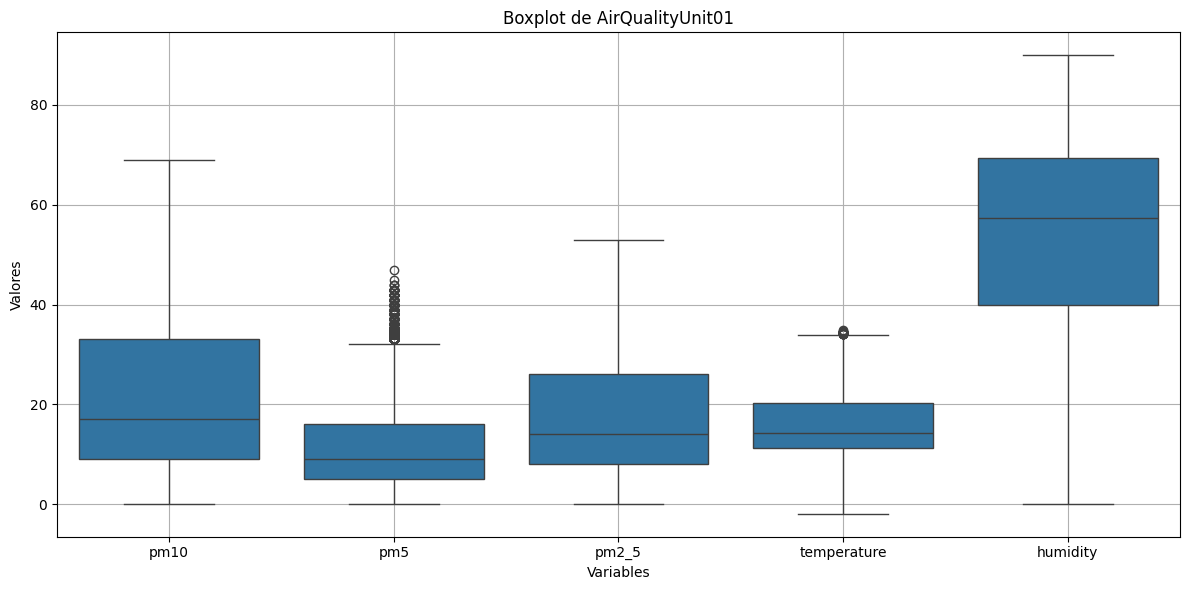

In [105]:
plot_all_boxplots(DF_AQ1, title="Boxplot de AirQualityUnit01",columns=['pm10', 'pm5','pm2_5','temperature','humidity'])


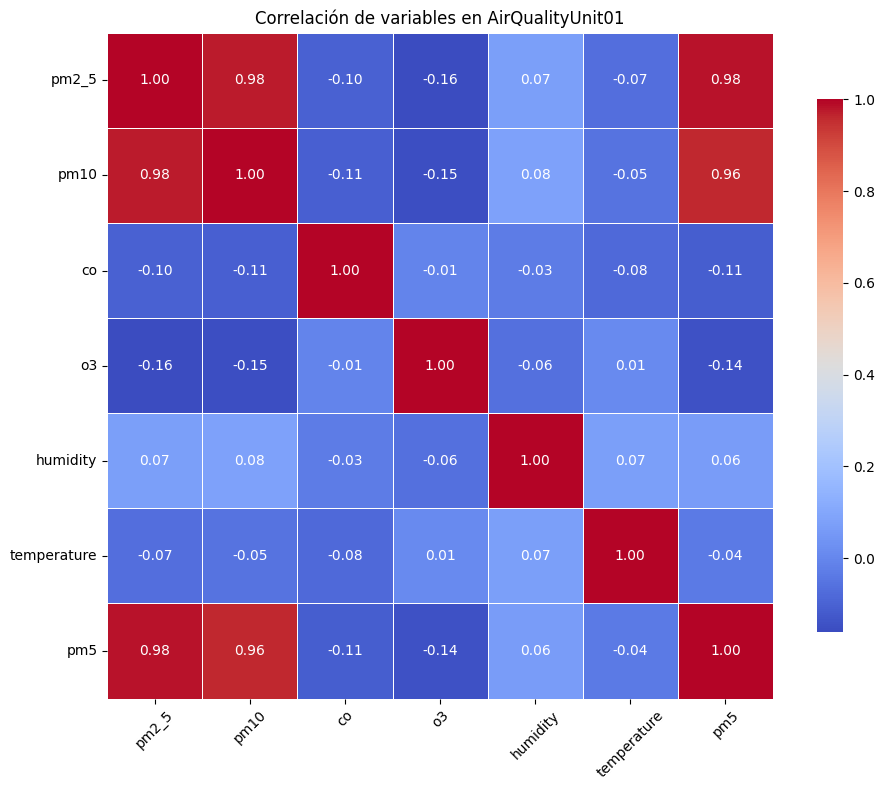

In [106]:
plot_correlation_map(DF_AQ1, title="Correlación de variables en AirQualityUnit01")


👉 Columna: pm2_5
📊 Registros antes: 31613
✅ Registros después de remover outliers: 28026


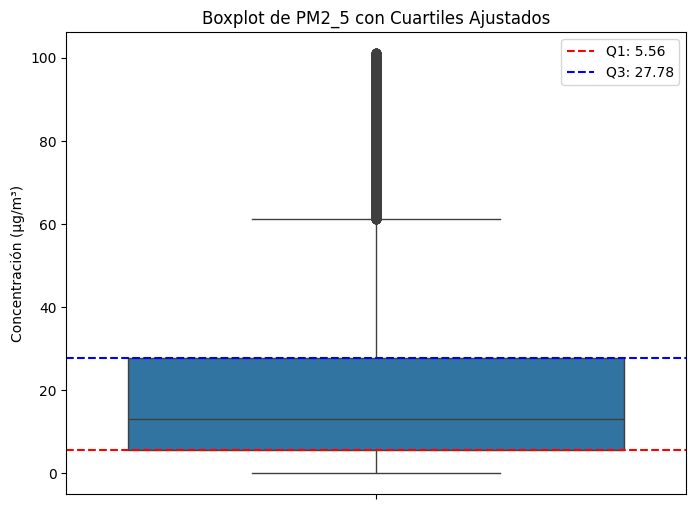

In [80]:
DFAQSEP_CPM2_5 = remove_outliers_and_plot_boxplot(DFAQSEP, 'pm2_5',1.5)

👉 Columna: pm10
📊 Registros antes: 28026
✅ Registros después de remover outliers: 23985


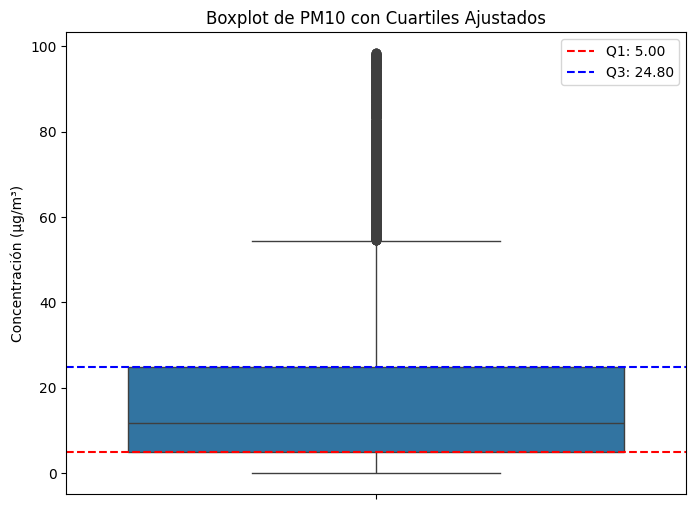

In [82]:
DFAQSEP_CPM2_5_1 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5, 'pm10',1.5)

👉 Columna: co
📊 Registros antes: 23985
✅ Registros después de remover outliers: 23969


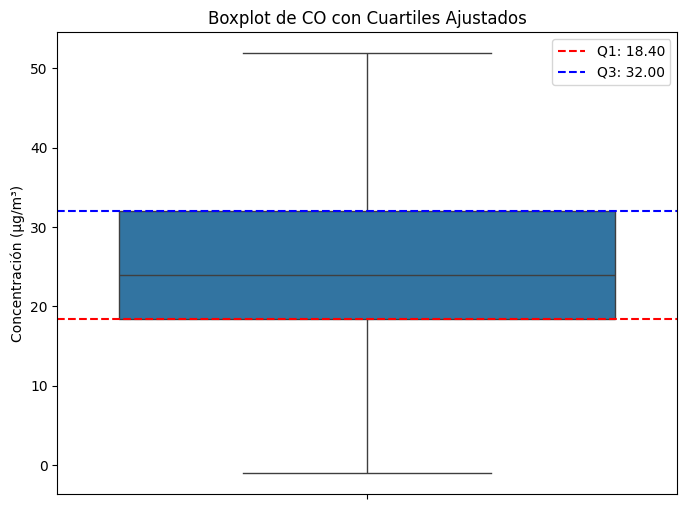

In [83]:
DFAQSEP_CPM2_5_2 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_1, 'co',1.5)

👉 Columna: humidity
📊 Registros antes: 23969
✅ Registros después de remover outliers: 18957


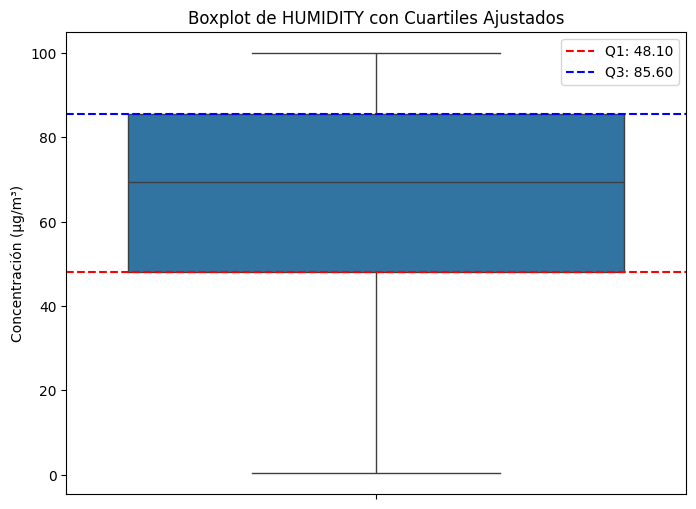

In [84]:
DFAQSEP_CPM2_5_3 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_2, 'humidity',1.5)

👉 Columna: temperature
📊 Registros antes: 18957
✅ Registros después de remover outliers: 18954


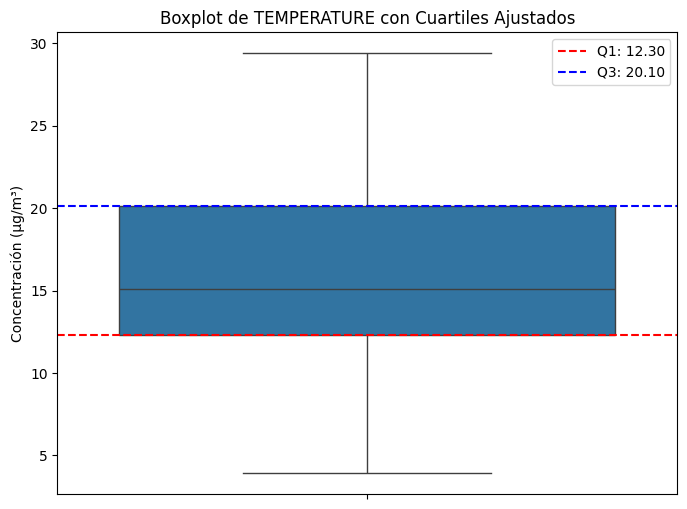

In [85]:
DFAQSEP_CPM2_5_4 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_3, 'temperature',1.5)

👉 Columna: o3
📊 Registros antes: 18954
✅ Registros después de remover outliers: 16895


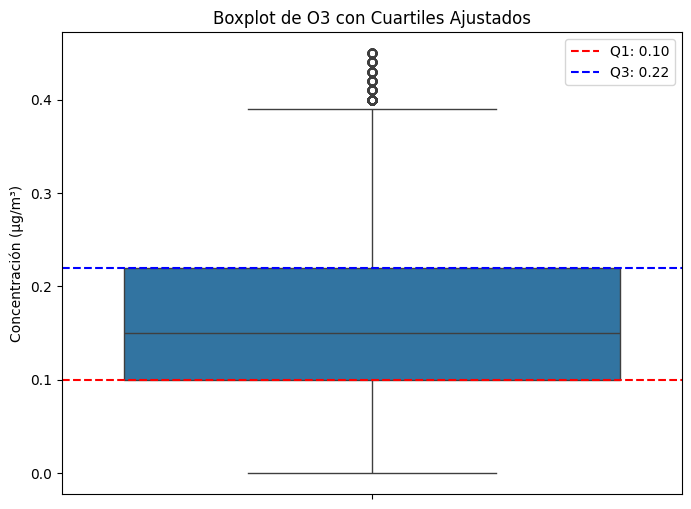

In [86]:
DFAQSEP_CPM2_5_5 = remove_outliers_and_plot_boxplot(DFAQSEP_CPM2_5_4, 'o3',1.5)

In [89]:
DF_AQSEP = DFAQSEP_CPM2_5_1

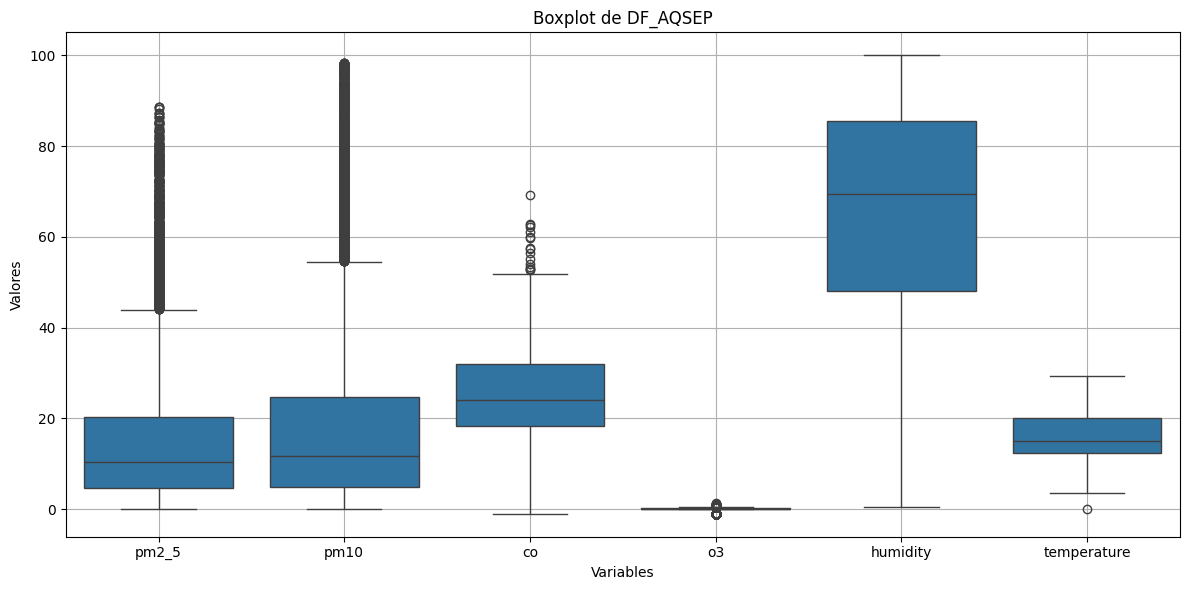

In [90]:
plot_all_boxplots(DF_AQSEP, title="Boxplot de DF_AQSEP")

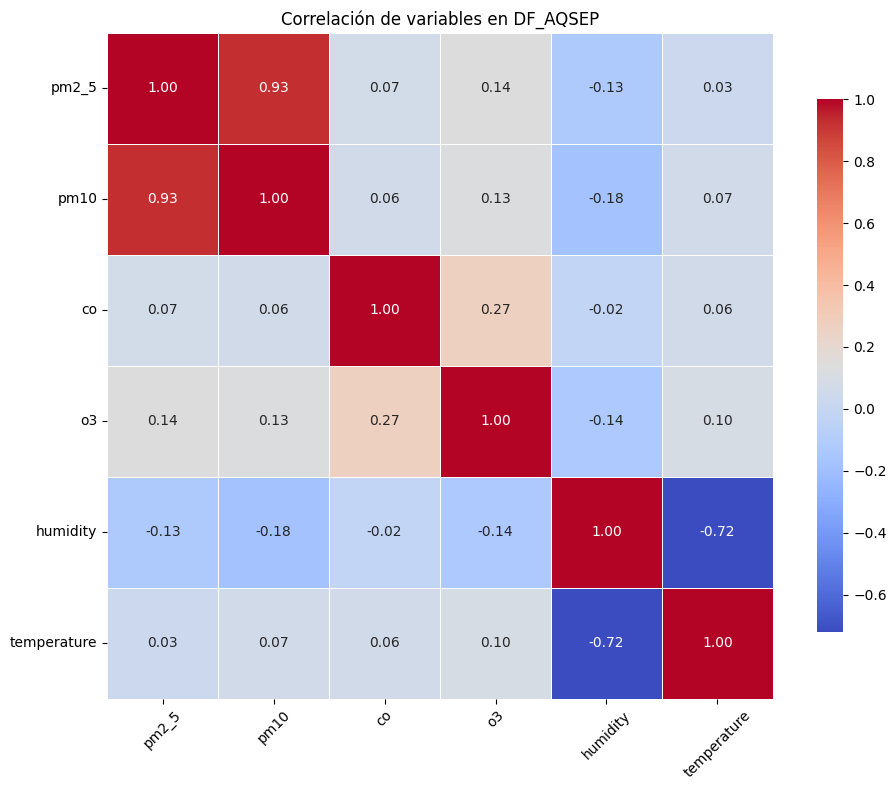

In [91]:
plot_correlation_map(DF_AQSEP, title="Correlación de variables en DF_AQSEP")

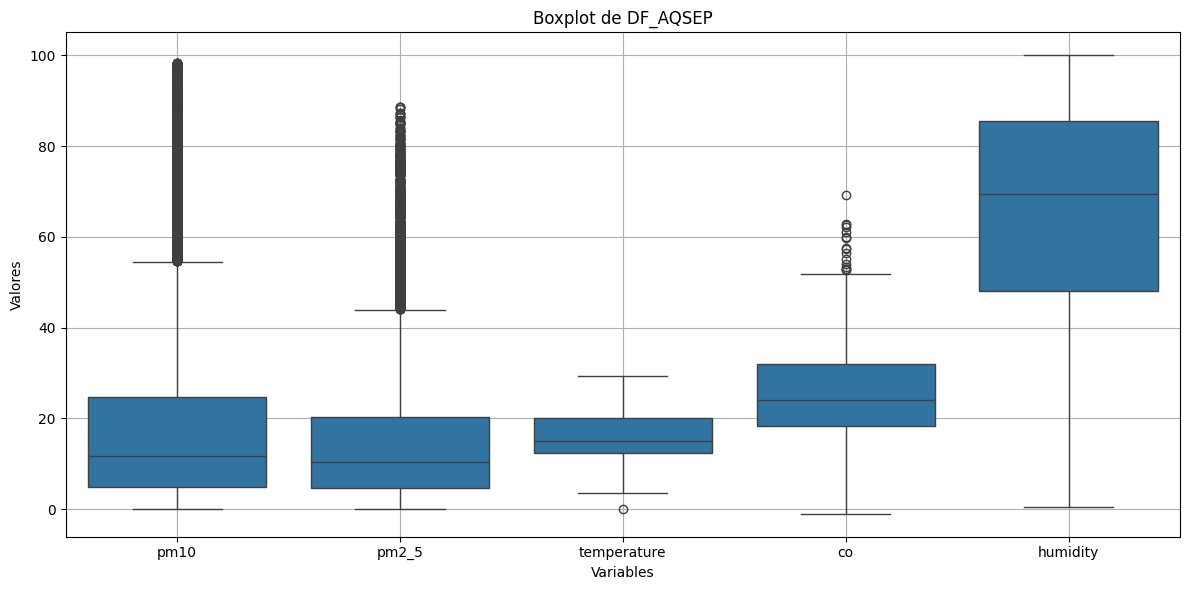

In [93]:
plot_all_boxplots(DF_AQSEP, title="Boxplot de DF_AQSEP",columns=['pm10','pm2_5', 'temperature', 'co', 'humidity'])

In [108]:
DF_AQ2_resampled = resample_dataframe_by_time(DF_AQ2, time_column='time_format', freq='H', agg_func='median')
DF_AQ1_resampled = resample_dataframe_by_time(DF_AQ1, time_column='time_format', freq='H', agg_func='median')
DF_AQSEP_resampled = resample_dataframe_by_time(DF_AQSEP, time_column='time_format', freq='H', agg_func='median')

/tmp/ipykernel_616738/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/tmp/ipykernel_616738/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/tmp/ipykernel_616738/737887448.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_resampled = df_copy.resample(freq).median()
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/air2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/steven-laptop/Documentos/Estudio/Proyecto QAIR/air_quality/air2/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keep

In [109]:
print(DF_AQ2_resampled.head())
print(DF_AQ1_resampled.head())
print(DF_AQSEP_resampled.head())

                     pm2_5  pm10    co   o3  humidity  temperature  pm5
time_format                                                            
2023-06-28 00:00:00   13.0  22.5  15.5  0.0      81.2        11.05  6.0
2023-06-28 01:00:00   10.0  13.0  12.5  0.0      83.9        10.90  5.0
2023-06-28 02:00:00   11.0  13.0  14.0  0.0      83.7        10.20  6.0
2023-06-28 03:00:00   13.0  21.0  17.0  0.0      85.7        10.30  6.0
2023-06-28 04:00:00   17.0  24.0  14.0  0.0      85.6        10.10  9.0
                     pm2_5  pm10    co   o3  humidity  temperature   pm5
time_format                                                             
2023-06-28 00:00:00    8.0  13.0  16.0  0.0      75.1         11.4   5.0
2023-06-28 01:00:00   18.0  22.0  14.0  0.0      79.6         10.5   9.0
2023-06-28 02:00:00   18.0  21.0  15.5  0.0      78.4         11.0   8.0
2023-06-28 03:00:00   21.0  26.0  14.0  0.0      81.6          9.7  10.0
2023-06-28 04:00:00   20.0  25.0  15.0  0.0      79.3     

In [110]:
DF_AQ1_resampled.count()
#DF_AQ2_resampled.count()
#DF_AQSEP_resampled.count()

pm2_5          9038
pm10           9038
co             9038
o3              790
humidity       9038
temperature    9038
pm5            9038
dtype: int64

In [111]:
def create_and_insert_resampled_tables(dataframes_dict):
    """
    Crea tablas en la base de datos si no existen y luego inserta los datos resampleados.

    Parámetros:
        dataframes_dict (dict): Diccionario con clave como nombre de la tabla y valor el DataFrame

    Retorna:
        None
    """
    if engine is None:
        raise Exception("⚠️ Debes ejecutar primero `connect_to_db()` para establecer la conexión.")

    inspector = inspect(engine)

    for table_name, df in dataframes_dict.items():
        try:
            # Verificar si la tabla ya existe
            if table_name in inspector.get_table_names():
                print(f"ℹ️ La tabla '{table_name}' ya existe. No se creó ni sobrescribió.")
            else:
                # Crear tabla e insertar datos
                df.to_sql(name=table_name, con=engine, if_exists='fail', index=True)
                print(f"✅ Tabla '{table_name}' creada y datos insertados ({len(df)} registros).")
        except Exception as e:
            print(f"❌ Error en la tabla '{table_name}': {e}")


In [112]:
resampled_dfs = {
    "DF_AQ2_RESAMPLED": DF_AQ2_resampled,
    "DF_AQ1_RESAMPLED": DF_AQ1_resampled,
    "DF_AQSEP_RESAMPLED": DF_AQSEP_resampled
}

create_and_insert_resampled_tables(resampled_dfs)


✅ Tabla 'DF_AQ2_RESAMPLED' creada y datos insertados (9936 registros).
✅ Tabla 'DF_AQ1_RESAMPLED' creada y datos insertados (9936 registros).
✅ Tabla 'DF_AQSEP_RESAMPLED' creada y datos insertados (9927 registros).
